In [1]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from config import DB_USERNAME, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME
from ipywidgets import interact, widgets
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Construct the connection string
database_access = f"postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# # Establish a connection to your PostgreSQL database 
engine = create_engine(database_access)

# # Write a SQL query to select data from a table 
query = 'SELECT * FROM "Total kWh"'

# Use Pandas to read the data from the SQL query into a DataFrame 
totalGWH = pd.read_sql_query(query, engine)

totalGWH.rename(columns={'Total kWh': 'GWh'}, inplace=True)
totalGWH['GWh'] = totalGWH['GWh'].round(0).astype(int)
totalGWH

month      GWh
0       1  7486647
1       2  6309523
2       3  6347116
3       4  5496082
4       5  5114708
5       6  4671075
6       7  4968417
7       8  5461721
8       9  5902973
9      10  6763362
10     11  7107314
11     12  7647396

In [3]:
query2 = "SELECT month, total_minutes FROM dates"

# Use Pandas to read the data from the SQL query into a DataFrame 
date_table = pd.read_sql_query(query2, engine)

date_table

month  total_minutes
0       1          26407
1       2          22255
2       3          22388
3       4          19386
4       5          18041
5       6          16476
6       7          17525
7       8          19265
8       9          20821
9      10          23856
10     11          25069
11     12          26974

In [4]:
# Merge the dataframes on the 'month' column
lightvsGwh = pd.merge(date_table, totalGWH, on='month')
lightvsGwh = lightvsGwh.rename(columns={'month': 'Month'})

lightvsGwh

Month  total_minutes      GWh
0       1          26407  7486647
1       2          22255  6309523
2       3          22388  6347116
3       4          19386  5496082
4       5          18041  5114708
5       6          16476  4671075
6       7          17525  4968417
7       8          19265  5461721
8       9          20821  5902973
9      10          23856  6763362
10     11          25069  7107314
11     12          26974  7647396

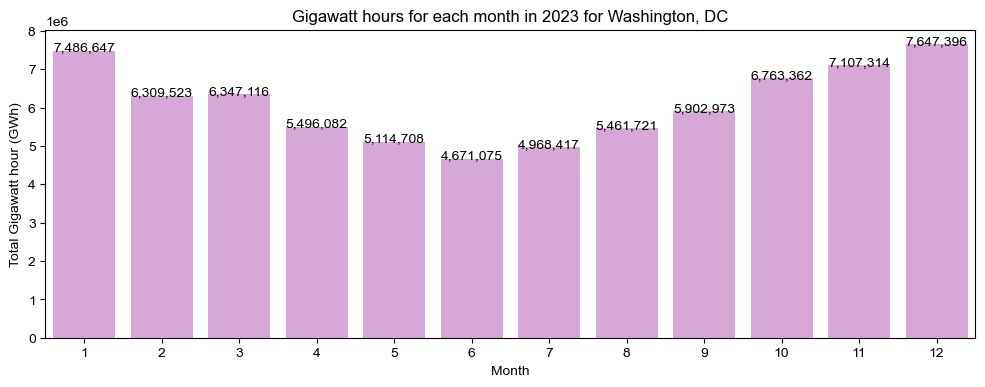

In [5]:
# Create the bar plot with 'month' as hue
plt.figure(figsize=(12, 4))
sns.barplot(data=lightvsGwh, x='Month', y='GWh', color='plum')

# Set the style
sns.set_style("whitegrid", {'grid.linestyle': '-'})

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Gigawatt hour (GWh)')
plt.title('Gigawatt hours for each month in 2023 for Washington, DC')

# Add hover labels with commas for GWh values
for index, value in enumerate(lightvsGwh['GWh']):
    formatted_value = '{:,.0f}'.format(value)  # Format the value with commas
    plt.text(index, value, formatted_value, color='black', ha='center')
 

#Save the plot as an image
# plt.savefig('../Screenshots/Gigawatt_bar.png')


# Display the plot
plt.show()

In [6]:
# Query the database
query3 = "SELECT * FROM lights"

# Use Pandas to read the data from the SQL query into a DataFrame 
lights_table = pd.read_sql_query(query3, engine)

lights_table.head()


x_coord    y_coord                light_type  number_of_lights  \
0 -77.051471  38.924794          INC-Incandescent               1.0   
1 -77.039700  38.931879  HPS-High Pressure Sodium               1.0   
2 -77.035274  38.937060          INC-Incandescent               1.0   
3 -77.042837  38.930995  HPS-High Pressure Sodium               1.0   
4 -77.035031  38.936375          INC-Incandescent               1.0   

  street_light_id   street_name  wattage1  total_wattage  
0         10219DC    WOODLEY PL     189.0          189.0  
1           10310     LAMONT ST      70.0           70.0  
2           13834     SPRING PL     189.0          189.0  
3           10373  KILBOURNE PL      70.0           70.0  
4           13849     SPRING PL     189.0          189.0

In [7]:

# Group the DataFrame by street name and light type, and aggregate the number of lights
grouped_df = lights_table.groupby(['street_name', 'light_type'])['number_of_lights'].sum().reset_index()

# Define unique street names
street_names = lights_table['street_name'].unique()

# Define colors for the pie chart using default color palette from Matplotlib
colors = plt.cm.tab10.colors 

def plot_pie_chart(street_name, chart_size):
    if street_name == 'All':
        aggregated_df = grouped_df.groupby('light_type')['number_of_lights'].sum().reset_index()
        labels = aggregated_df['light_type']
        sizes = aggregated_df['number_of_lights']
        title = 'Number of Lights by Light Type - All Streets'
    else:
        filtered_df = grouped_df[grouped_df['street_name'] == street_name]
        labels = filtered_df['light_type']
        sizes = filtered_df['number_of_lights']
        title = f'Number of Lights by Light Type - {street_name}'
    
    plt.figure(figsize=(chart_size, chart_size))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
    plt.title(title)
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')  
    plt.show()

# Modify the dropdown options to include an option for 'All Streets'
all_options = ['All'] + list(street_names)
interact(plot_pie_chart, street_name=widgets.Dropdown(options=all_options, description='Select Street Name:'), chart_size=(4, 12, 1))

#Save the plot as an image
# plt.savefig('../Screenshots/interactive_pie.png')

interactive(children=(Dropdown(description='Select Street Name:', options=('All', 'WOODLEY PL', 'LAMONT ST', '…

<Figure size 640x480 with 0 Axes>

In [10]:
# Convert the DataFrame to a GeoDataFrame
geo_coordinates = [Point(xy) for xy in zip(lights_table['x_coord'], lights_table['y_coord'])]
geo_df = gpd.GeoDataFrame(lights_table, geometry=geo_coordinates)

# # # Plot based on coordinates, light description, total wattage
fig = px.scatter_mapbox(geo_df,  
                        lat=geo_df.geometry.y,  
                        lon=geo_df.geometry.x,  
                        color='light_type', 
                        size='total_wattage',  
                        mapbox_style="carto-positron",
                        zoom=10)

fig.update_layout(title='Washington DC Map by Light Types and Wattage',
                  margin={"r":0,"t":30,"l":0,"b":0},
                  mapbox=dict(
                      center=dict(lat=geo_df.geometry.y.mean(), lon=geo_df.geometry.x.mean()),  
                      style="carto-positron",
                      zoom=10),
                  width=1200, 
                  height=800 
                 )

fig.show()
#Save the plot as an image
# plt.savefig('../Screenshots/Map.png')

<Figure size 640x480 with 0 Axes>